# Data Exploration

In [1]:
#Data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import butter


#For building ML models
import keras
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
import keras.layers as layers
from keras.utils import to_categorical

Using TensorFlow backend.


## 1. Process raw data

In [2]:
!ls data

mqxfs1b.Quench.161011115654_all_1.txt mqxfs1b.Quench.161011115654_all_4.txt
mqxfs1b.Quench.161011115654_all_2.txt mqxfs1b.Quench.161011115654_all_5.txt
mqxfs1b.Quench.161011115654_all_3.txt


In [3]:
def read_data(filepath):
    """Read in quench data from a given file, return a pandas dafa frame"""
    
    data_dict= {}
    
    with open(filepath) as f:
        content = f.readlines()
    #Remove`\n` at the end of each line
    content = [x.strip() for x in content]
    
    column_names = content[0].split(" ")
    data = [content[i].split("   ") for i in range(1, len(content))] 
    
    for i in range(len(column_names)):
        data_dict[column_names[i]] = [float(x[i]) for x in data]
        
    data_frame = pd.DataFrame(data_dict)
    
    return data_frame

In [4]:
data_1 = read_data("./data/mqxfs1b.Quench.161011115654_all_1.txt")
data_2 = read_data("./data/mqxfs1b.Quench.161011115654_all_2.txt")
data_3 = read_data("./data/mqxfs1b.Quench.161011115654_all_3.txt")
data_4 = read_data("./data/mqxfs1b.Quench.161011115654_all_4.txt")
data_5 = read_data("./data/mqxfs1b.Quench.161011115654_all_5.txt")

In [5]:
#Don't care about when t > 0
#data_1 = data_1[data_1["time"] < 0]
#data_3 = data_3[data_3["time"] < 0]

### 1.2. Explore the data

I'm just plotting every variables with time to see what's in there!

In [6]:
def plot_variables_with_time(data, variables = None, time_range = None):
    """
    Take a data frame, and plot all other variables with time.
    Optional argument: time_range to specify the range to plot, default is to plot all time. Example argument
    is (start_time, end_time)
    """
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    if variables:
        for variable in variables:
            plt.plot(data["time"], data[variable])
            plt.title("Variable {}".format(variable))
            plt.show()
        
    else:      
        #If variables not specified then just plot all 
        for variable in data.columns[1:]:
            plt.plot(data["time"], data[variable])
            plt.title("Variable {}".format(variable))
            plt.show()

In [7]:
#plot_variables_with_time(data_1, time_range = (-1, -13e-3))

### 1.3 Denoising the signal

**Try moving average**

In [8]:
def plot_moving_average(data, variables = None, time_range = None, window = 100):
    """Take a data frame and plot the variable with its moving average and real data in the specified range, if
    variables are not specified then just plot all variables by default"""
    #Pickout the data
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    def plot_noise_and_average(variable):
        # Plotted by calculating Simple Moving Average (SMA)
        plt.plot(data["time"], data[variable], label = "Signal with noise")
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).mean(),label = "Moving average")
        plt.legend(loc = "best")
        plt.title("Variable {}".format(variable))
        plt.show()
    
    #Plot
    if variables:
        for variable in variables:
            plot_noise_and_average(variable)         
    else:
        for variable in data.columns[1:]:
            plot_noise_and_average(variable)

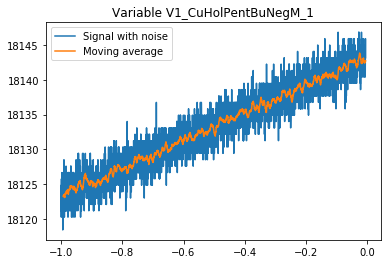

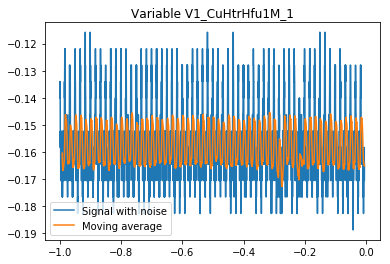

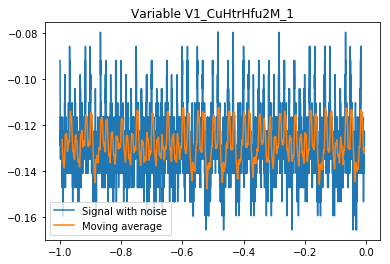

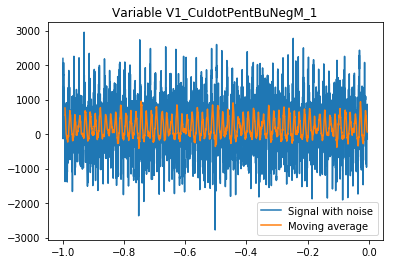

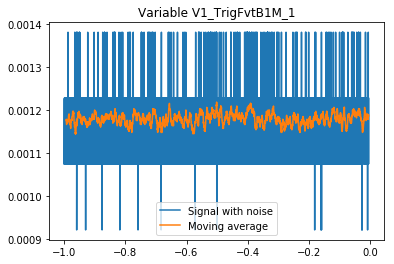

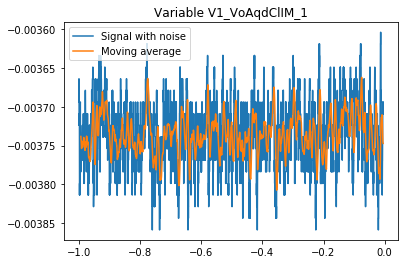

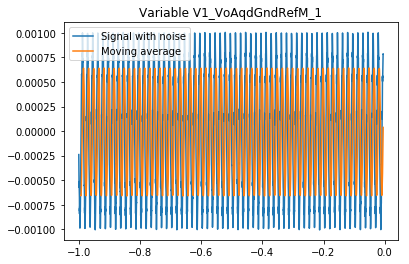

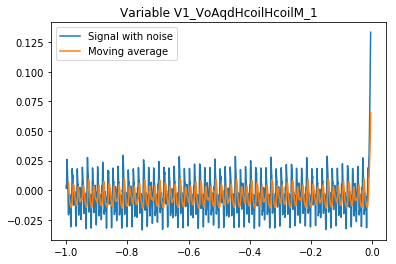

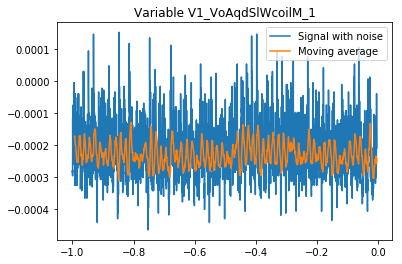

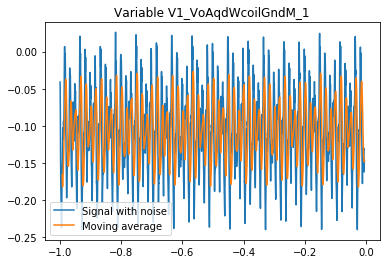

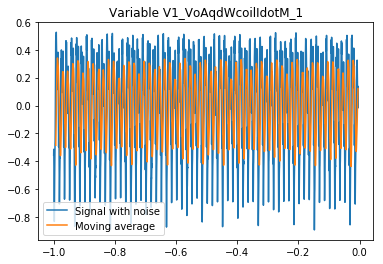

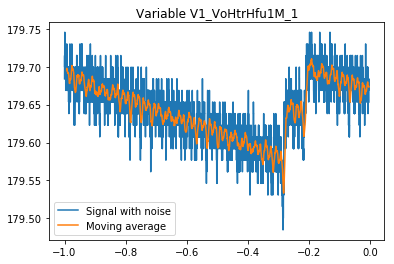

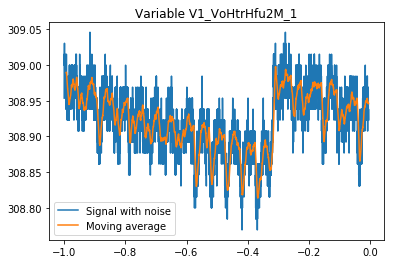

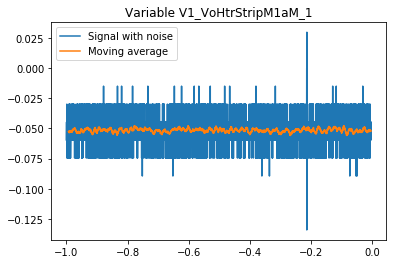

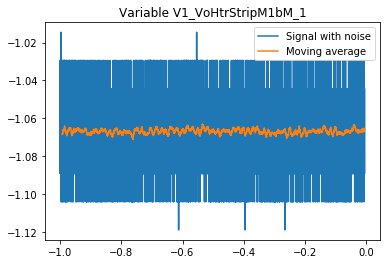

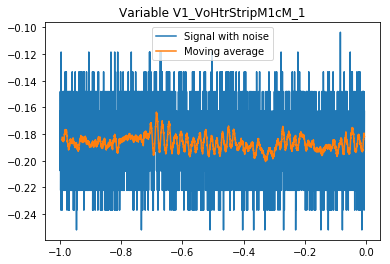

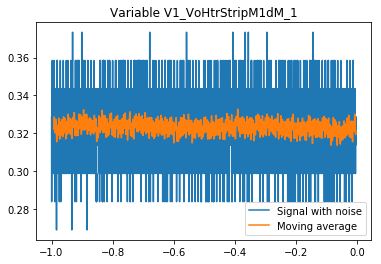

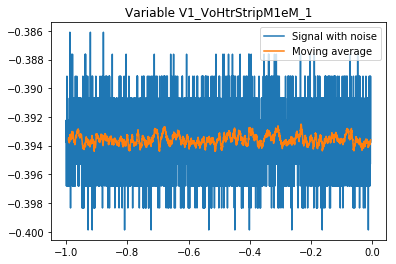

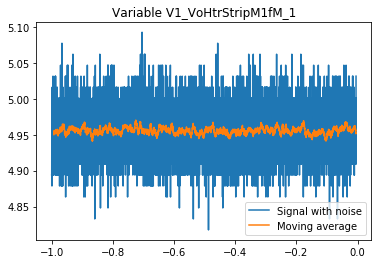

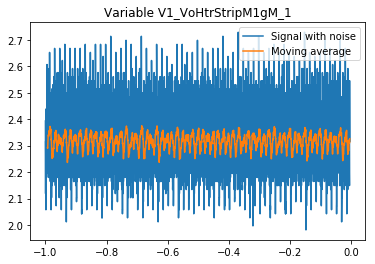

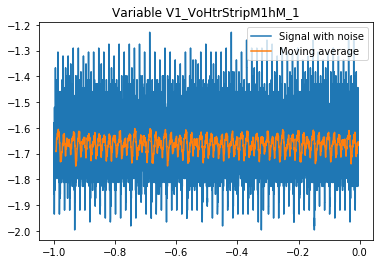

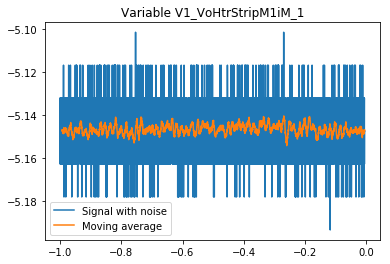

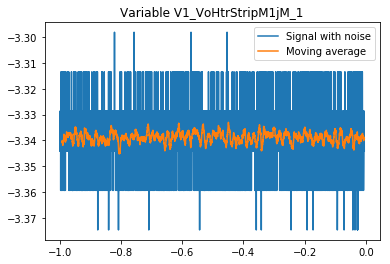

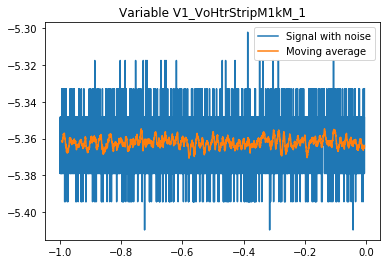

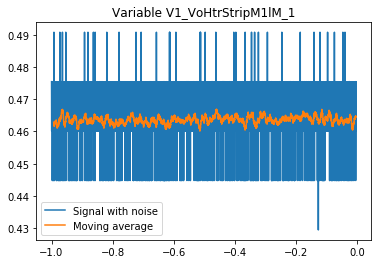

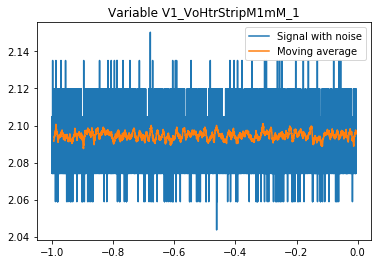

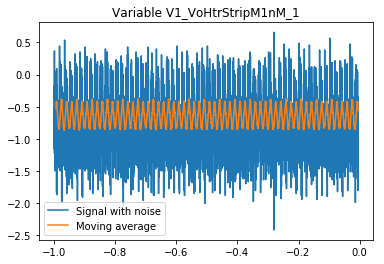

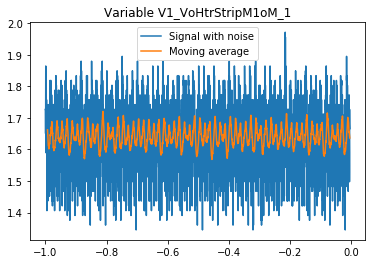

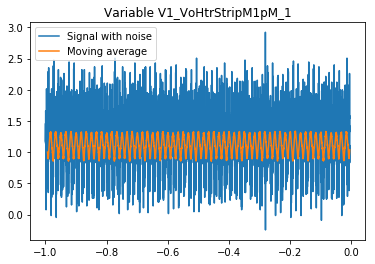

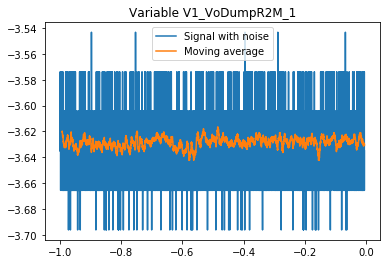

In [9]:
plot_moving_average(data_3, time_range = (-1,-5e-3), window = 50)

**Try low-pass filter**

In [10]:
def low_pass_filter(data, signal_frequency, variables = None, time_range = None):
    from scipy.signal import butter,filtfilt #Scipy signal has a lot of processing functions!!
    """Take a data frame and plot the variable with its low-pass filted data and real data in the specified range, if
    variables are not specified then just plot all variables by default"""
    #Pickout the data
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    # Filter requirements.
    T = abs(start-end)         # Sample Period
    fs = 7000.0     # sample rate, Hz
    cutoff = signal_frequency # desired cutoff frequency of the filter (Hz)
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2       # Approximation order
    n = int(T * fs) # Total number of samples
    
    def butter_lowpass_filter(data, cutoff, fs, order):
        normal_cutoff = cutoff / nyq
        # Get the filter coefficients 
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y
    
    def plot_noise_and_filtered(variable):
        plt.plot(data["time"], data[variable], label = "Signal with noise")
        
        #Low-pass filter
        plt.plot(data["time"],  butter_lowpass_filter(data[variable], cutoff, fs, order),label = "Filtered signal")
        plt.legend(loc = "best")
        plt.title("Variable {}".format(variable))
        plt.show()
    
    #Plot using 
    if variables:
        for variable in variables:
            plot_noise_and_filtered(variable)
    else:
        for variable in data.columns[1:]:
            plot_noise_and_filtered(variable)

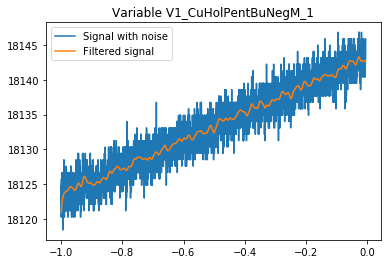

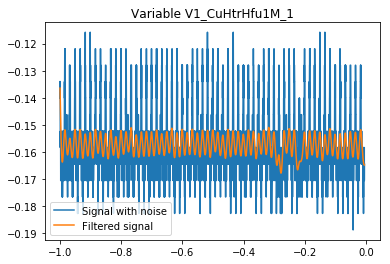

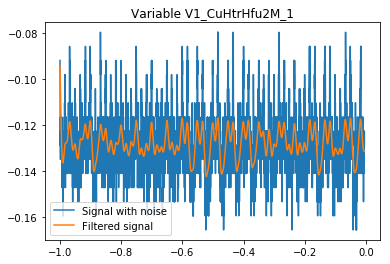

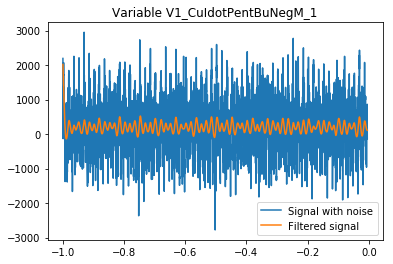

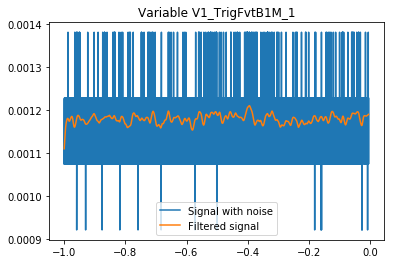

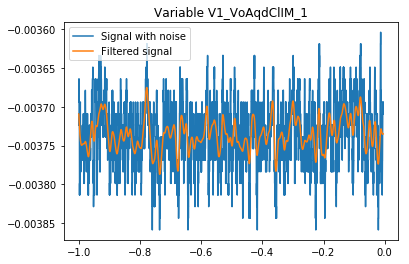

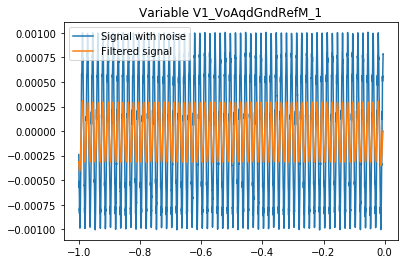

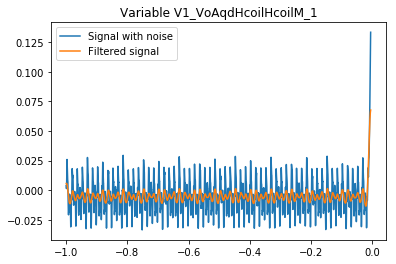

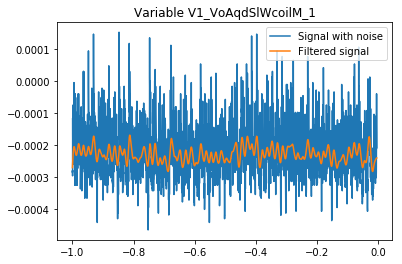

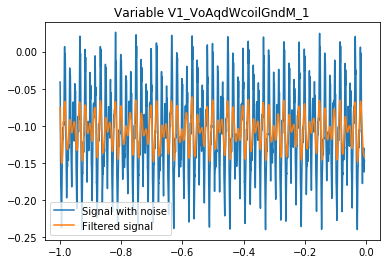

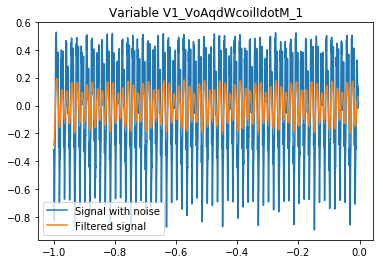

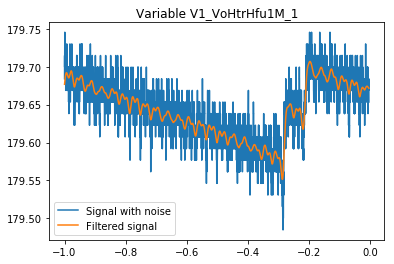

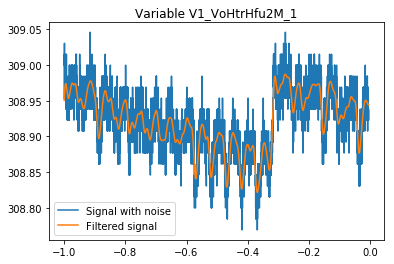

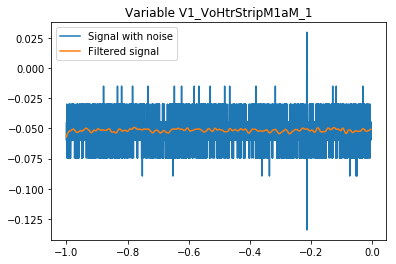

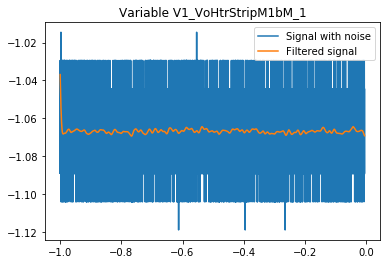

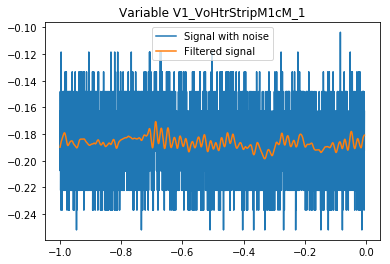

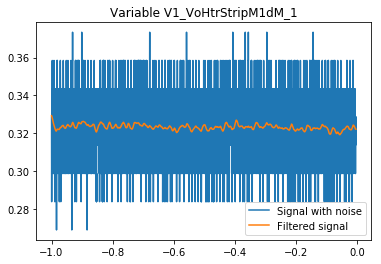

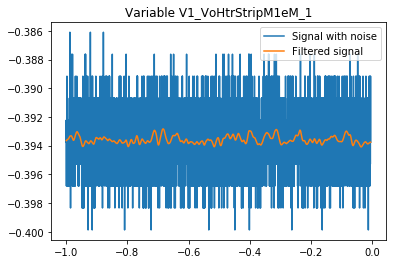

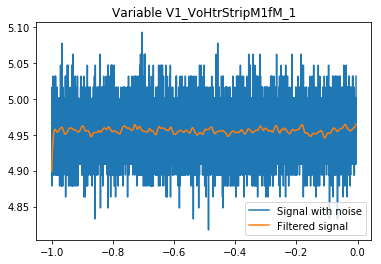

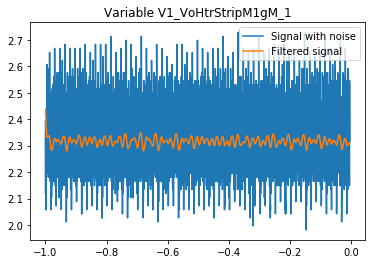

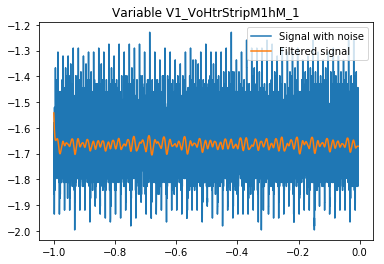

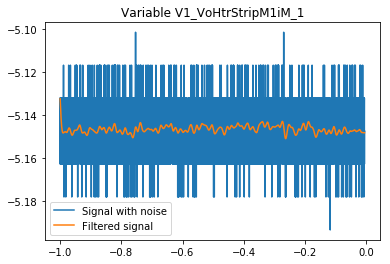

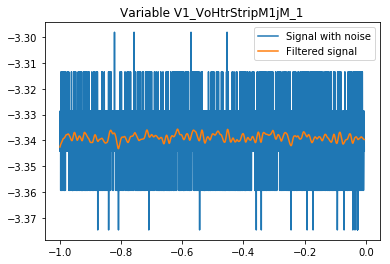

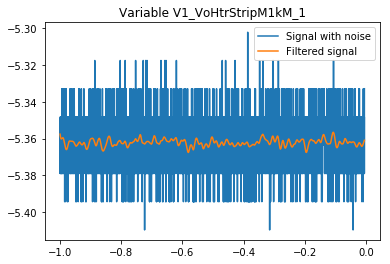

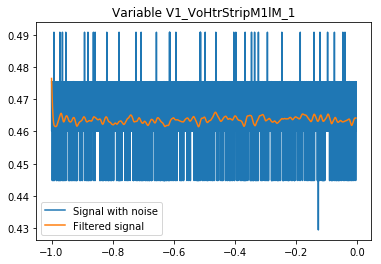

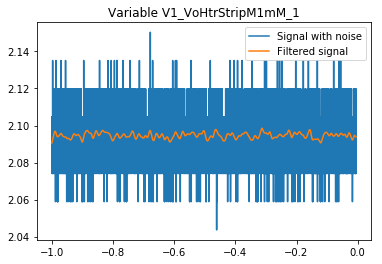

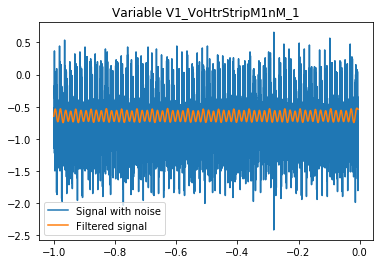

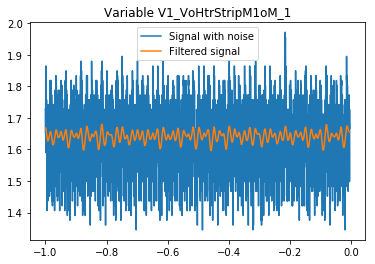

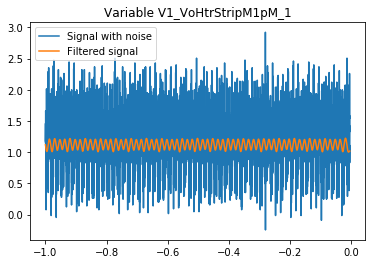

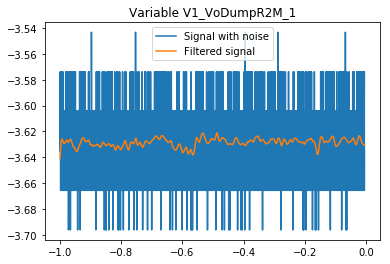

In [12]:
low_pass_filter(data_3, signal_frequency=50, time_range = (-1,-5e-3))

## Experiment 1

**IDEA:** To find the difference between the background noise and "queching signals", my idea (as Nhan recommend) is to build a generic ML model to seperate the two signals. If the model performs well, then we can basically "trace back" the model and only look into the encoder part, and see why it was able to detect the "quenching signals".

### Detailed implementation

Since the currently available data is limited, I need to utilize it as much as possible. I attempted to write the code so it's as general as possible, and can be adapted to future data as easily as possible. 

First, I only take out the signals from (-1s,-13ms), since it's basically the only part we care about (as for now). Then, I separated the signals at -500ms (just a guess as to where it will be efficient), therby dividing the data into to classes:

- (-1s,-500ms): For now just classify them as back ground noise (0).
- (-500ms, -13ms): Classify samples in this range as "queching signals" (1). 

To generate a data set, I used a "sliding window" (as briefly explained in my first email) to collect samples of 512 data points. Since the data rate is 7Hz, a new data points will come in at every 0.14ms, so a sample will be (512 x 0.14) = 71.68ms long.

**NOTE:** Initial experiment will just use the current and voltage's data, if it shows some promise we might try to combine more variables. 

In [ ]:
#Gather the data just for the current and voltage variable 
#(i.e V1_CuHolPentBuNegM_1 in "3" and V1_VoTap003A04_003A03M_1 in "1")
data = pd.merge(data_3[['time','V1_CuHolPentBuNegM_1']], data_1[['time','V1_VoTap003A04_003A03M_1']])

#Plot
plot_variables_with_time(data)

In [ ]:
#Divide the data as described above
data_noise = data[(data['time'] > -1) & (data['time'] < -500e-3)]
data_quench = data[(data['time'] > -500e-3) & (data['time'] < -13e-3)]

#Strip out the time column, since we don't need it for training
data_noise = data_noise.drop(['time'], axis = 1)
data_quench = data_quench.drop(['time'], axis = 1)

#Convert to numpy array
data_noise = data_noise.to_numpy()
data_quench = data_quench.to_numpy()

print("Data_noise's shape: ", data_noise.shape)
print("Data_quench's shape: ", data_quench.shape)

In [ ]:
X_noise = []
X_quench = []

#Use a "sliding window" to collect the samples
for i in range(data_noise.shape[0] - 512):
    X_noise.append(data_noise[i:i+512])
    
for j in range(data_quench.shape[0] - 512):
    X_quench.append(data_quench[j:j+512])

X_noise = np.asarray(X_noise)
X_quench = np.asarray(X_quench)

print("X_noise's shape: ", X_noise.shape)
print("X_quech's shape: ", X_quench.shape)

#Generate correponding labels
y_noise = np.zeros(X_noise.shape[0])
y_quench = np.ones(X_quench.shape[0])

print("y_noise's shape: ", y_noise.shape)
print("y_quech's shape: ", y_quench.shape)

print("Noise class is ", y_noise.shape[0]/(y_quench.shape[0]+y_noise.shape[0]))
print("Quench class is ", y_quench.shape[0]/(y_quench.shape[0]+y_noise.shape[0]))

In [ ]:
#Combine the data together
X = np.concatenate((X_noise, X_quench), axis =0)
y = np.concatenate((y_noise, y_quench), axis =0)

print("X's shape ", X.shape)
print("y's shape ", y.shape)

In [ ]:
#And randomly suffle them for training, validation, and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("X_train shape ", X_train.shape)
print("X_test shape ", X_test.shape)
print("y_train shape ", y_train.shape)
print("y_test shape ", y_test.shape)

### 1. Try CNN for this 

In [ ]:
input_shape = X_train[0].shape
num_classes = 1

In [ ]:
#================BUILD THE MODEL====================
print("Preparing the model ...")
print("Input shape: ", input_shape)
print("Using Keras version: ", keras.__version__)

# Conv1d model
model = models.Sequential()
model.add(Conv1D(100, 10, activation='relu', input_shape=input_shape))
model.add(Conv1D(100, 10, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(160, 10, activation='relu'))
model.add(Conv1D(160, 10, activation='relu'))
model.add(layers.GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

#
from keras.optimizers import SGD
opt = SGD(lr=0.1)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

In [ ]:
#================TRAIN THE MODEL====================

print('# Fit model on training data')
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test))

print('\nhistory dict:', history.history)

### Try LSTM

In [ ]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=input_shape))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
#================TRAIN THE MODEL====================

print('# Fit model on training data')
history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=50,
                    validation_data=(X_test, y_test))

print('\nhistory dict:', history.history)